In [1]:
!pip install git+https://github.com/onnx/tensorflow-onnx

  Cloning https://github.com/onnx/tensorflow-onnx to /tmp/pip-req-build-mzyro2oy
  Running command git clone --filter=blob:none --quiet https://github.com/onnx/tensorflow-onnx /tmp/pip-req-build-mzyro2oy
  Resolved https://github.com/onnx/tensorflow-onnx to commit 72c4bdec6163bc2a41ebc60de0c3e12398118d1f
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 87.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 15.5 MB/s eta 0:00:00
  Created wheel for tf2onnx: filename=tf2onnx-1.16.1-py3-none-any.whl size=456694 sha256=83fb4b612ce6678630a80f093e30218aa795aaf91a2ac137bdc13482c6482cba
  Stored in directory: /tmp/pip-ephem-wheel-cache-90lab14c/wheels/b9/59/ad/796a7a463db709029269f06ba58ff2526b3c71aa9e922d47e9
Successfully built tf2onnx
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.5
    Uninstalling protobuf-4.25.5:
      Successfully uninstalled protobuf-4.25.5
ERROR: pip's dependency

In [1]:
import tensorflow as tf
class Conv2DBatchNormReLU(tf.keras.layers.Layer):
    def __init__(self, filters, l2=1e-4, kernel_size=3, **kwargs):
        super().__init__(**kwargs)
        self.conv2d = tf.keras.layers.Conv2D(
            filters=filters,
            kernel_size=kernel_size,
            padding="same",
            use_bias=False,
            kernel_initializer=tf.keras.initializers.HeUniform(),
            kernel_regularizer=tf.keras.regularizers.l2(l2),
        )
        self.batch_norm = tf.keras.layers.BatchNormalization(
            epsilon=1e-5, momentum=0.9,
            beta_regularizer=tf.keras.regularizers.l2(l2),
            gamma_regularizer=tf.keras.regularizers.l2(l2)
        )

    def call(self, inputs, training=False):
        x = self.conv2d(inputs)
        x = self.batch_norm(x, training=training)
        return tf.nn.relu(x)


class ResNet9Block(tf.keras.layers.Layer):
    def __init__(self, filters, l2=1e-4, kernel_size=3, **kwargs):
        super().__init__(**kwargs)
        self.conv_bn_relu_1 = Conv2DBatchNormReLU(filters=filters, l2=l2, kernel_size=kernel_size)
        self.conv_bn_relu_2 = Conv2DBatchNormReLU(filters=filters, l2=l2, kernel_size=kernel_size)
        self.downsample = tf.keras.layers.Conv2D(
            filters=filters,
            kernel_size=1,
            strides=2,
            padding='SAME',
            use_bias=False,
            kernel_regularizer=tf.keras.regularizers.l2(l2)
        )
        self.batch_norm = tf.keras.layers.BatchNormalization(
            epsilon=1e-5, momentum=0.9,
            beta_regularizer=tf.keras.regularizers.l2(l2),
            gamma_regularizer=tf.keras.regularizers.l2(l2)
        )
        self.max_pool2d = tf.keras.layers.MaxPool2D(pool_size=2)

    def call(self, inputs, training=False):
        shortcut = self.downsample(inputs)
        shortcut = self.batch_norm(shortcut, training=training)

        x = self.conv_bn_relu_1(inputs, training=training)
        x = self.max_pool2d(x)
        x = self.conv_bn_relu_2(x, training=training)

        return tf.nn.relu(x + shortcut)


# Load the model with custom layers
model = tf.keras.models.load_model(
    "/content/CIFAR-TUNED-RESNET9-AUG.keras",
    custom_objects={
        "Conv2DBatchNormReLU": Conv2DBatchNormReLU,
        "ResNet9Block": ResNet9Block
    }
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'conv2d_batch_norm_re_lu', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'res_net9_block', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'conv2d_batch_norm_re_lu_3'

In [2]:
tf.saved_model.save(model, "tmp_model")
!python3 -m tf2onnx.convert --saved-model tmp_model --output "model.onnx"

2025-01-22 16:28:42.455901: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-22 16:28:42.475702: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-22 16:28:42.481736: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-22 16:28:43.720861: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
<frozen runpy>:128: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
2025-01-22 16:28:46,432 - WARNING - ***IMPO

In [3]:
!apt-get update
!apt-get install -y python3-libnvinfer libnvinfer-bin libnvinfer-dev

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:6 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,646 kB]
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,228 kB]
Get:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy/main amd64 Packages [53.6 kB]
Get:13 http://archive.ubuntu.co

In [4]:
!dpkg -l | grep nvinfer

ii  libnvinfer-bin                         10.7.0.23-1+cuda12.6                    amd64        TensorRT binaries
ii  libnvinfer-dev                         10.7.0.23-1+cuda12.6                    amd64        TensorRT development libraries
ii  libnvinfer-dispatch10                  10.7.0.23-1+cuda12.6                    amd64        TensorRT dispatch runtime library
ii  libnvinfer-headers-dev                 10.7.0.23-1+cuda12.6                    amd64        TensorRT development headers
ii  libnvinfer-lean10                      10.7.0.23-1+cuda12.6                    amd64        TensorRT lean runtime library
ii  libnvinfer-plugin10                    10.7.0.23-1+cuda12.6                    amd64        TensorRT plugin libraries
ii  libnvinfer-vc-plugin10                 10.7.0.23-1+cuda12.6                    amd64        TensorRT vc-plugin library
ii  libnvinfer10                           10.7.0.23-1+cuda12.6                    amd64        TensorRT runtime libraries
ii  python

In [5]:
!/usr/src/tensorrt/bin/trtexec --onnx=/content/model.onnx --saveEngine=/content/model.trt --fp16

&&&& RUNNING TensorRT.trtexec [TensorRT v100700] [b23] # /usr/src/tensorrt/bin/trtexec --onnx=/content/model.onnx --saveEngine=/content/model.trt --fp16
[01/22/2025-16:35:32] [I] === Model Options ===
[01/22/2025-16:35:32] [I] Format: ONNX
[01/22/2025-16:35:32] [I] Model: /content/model.onnx
[01/22/2025-16:35:32] [I] Output:
[01/22/2025-16:35:32] [I] === Build Options ===
[01/22/2025-16:35:32] [I] Memory Pools: workspace: default, dlaSRAM: default, dlaLocalDRAM: default, dlaGlobalDRAM: default, tacticSharedMem: default
[01/22/2025-16:35:32] [I] avgTiming: 8
[01/22/2025-16:35:32] [I] Precision: FP32+FP16
[01/22/2025-16:35:32] [I] LayerPrecisions: 
[01/22/2025-16:35:32] [I] Layer Device Types: 
[01/22/2025-16:35:32] [I] Calibration: 
[01/22/2025-16:35:32] [I] Refit: Disabled
[01/22/2025-16:35:32] [I] Strip weights: Disabled
[01/22/2025-16:35:32] [I] Version Compatible: Disabled
[01/22/2025-16:35:32] [I] ONNX Plugin InstanceNorm: Disabled
[01/22/2025-16:35:32] [I] TensorRT runtime: full
[

In [6]:
!pip install tensorrt

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for tensorrt: filename=tensorrt-10.7.0-py2.py3-none-any.whl size=16336 sha256=ae30e24e93ea34417988b2afa0dad05bc32ca6058d11ae965e59cb7d43c7d623
  Stored in directory: /root/.cache/pip/wheels/d6/d9/8e/9c3f248355e21ed1a3a2c923b21f48ac7dabae3e2f7ec31ce7
  Created wheel for tensorrt_cu12: filename=tensorrt_cu12-10.7.0-py2.py3-none-any.whl size=17551 sha256=87cdd19e97125d726599b4fecb3a47d03c9d7cdc1fe2257839ad29e4967e726d
  Stored in directory: /root/.cache/pip/wheels/f9/b8/b1/c8b6c821e7dc08ebe34022fbf297874db54a6c23a3876210a3
Successfully built tensorrt tensorrt_cu12


In [7]:
!pip install pycuda

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 55.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.8/92.8 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.9 MB/s eta 0:00:00
  Created wheel for pycuda: filename=pycuda-2024.1.2-cp311-cp311-linux_x86_64.whl size=660362 sha256=4d78eb084d732053aa2fe202f943646b1c4005b7764041e135adf438dd1f1452
  Stored in directory: /root/.cache/pip/wheels/76/66/50/c65e6116d7e0e16abe0f7c19b50327f76724ccfefbdc61a1b9
Successfully built pycuda


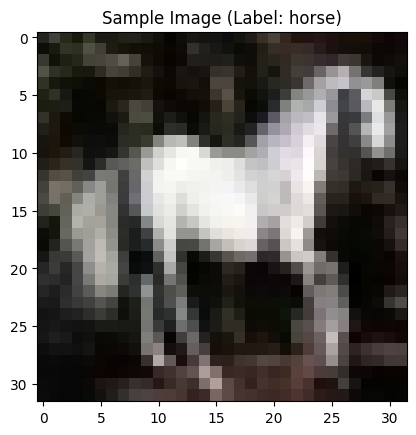

Predicted label: horse
Latency: 0.000419 s


In [21]:
import time
import numpy as np
import pycuda.driver as cuda
import pycuda.autoinit
import tensorrt as trt
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf

# CIFAR-10 class labels for prediction
class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def preprocess_image(image, input_shape):
    """
    Preprocess the input CIFAR-10 image: resize, normalize, and format for TensorRT.
    CIFAR-10 images are 32x32, resizing them to 224x224.
    """
    image = Image.fromarray(image).convert('RGB')  # Convert to RGB
    image = image.resize((input_shape[2], input_shape[1]))  # Resize to 224x224
    image_array = np.array(image, dtype=np.float32).transpose(2, 0, 1)  # Convert from HWC to CHW
    image_array /= 255.0  # Normalize to [0, 1] (assuming input data is normalized this way)
    return np.expand_dims(image_array, axis=0).copy()  # Add batch dimension and make it contiguous

def load_engine(engine_path):
    """
    Load the TensorRT engine.
    """
    TRT_LOGGER = trt.Logger(trt.Logger.WARNING)
    with open(engine_path, 'rb') as f, trt.Runtime(TRT_LOGGER) as runtime:
        return runtime.deserialize_cuda_engine(f.read())

def infer(engine, context, image_array, input_shape, output_shape):
    """
    Perform inference on a single image and measure latency.
    """
    # Allocate device memory
    d_input = cuda.mem_alloc(int(np.prod(input_shape) * np.dtype(np.float32).itemsize))  # cast to int
    d_output = cuda.mem_alloc(int(np.prod(output_shape) * np.dtype(np.float32).itemsize))  # cast to int

    # Transfer input to GPU
    cuda.memcpy_htod(d_input, image_array)

    # Perform inference
    bindings = [int(d_input), int(d_output)]
    start_time = time.time()
    context.execute_v2(bindings=bindings)
    end_time = time.time()

    # Transfer output back to CPU
    output = np.empty(output_shape, dtype=np.float32)
    cuda.memcpy_dtoh(output, d_output)

    latency = (end_time - start_time) * 1000  # Convert to milliseconds
    return output, latency

def measure_latency_and_predict(model_path, image, input_shape=(1, 3, 224, 224), output_shape=(1, 10)):
    """
    Load the TensorRT model, preprocess the image, run inference, and measure latency.
    """
    # Load TensorRT engine
    engine = load_engine(model_path)
    context = engine.create_execution_context()

    # Preprocess the CIFAR-10 image
    image_array = preprocess_image(image, input_shape).astype(np.float32)

    # Perform inference
    output, latency = infer(engine, context, image_array, input_shape, output_shape)

    # Get the predicted class label index (highest probability)
    predicted_class = np.argmax(output)

    return predicted_class, latency
# Main Script: Processing CIFAR-10 Image
(_, _), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()  # Load CIFAR-10 dataset
ind=13
sample_image = x_test[ind]  # Select a sample image from the test set

# Plot the sample image
plt.imshow(sample_image)
plt.title(f"Sample Image (Label: {class_labels[y_test[ind][0]]})")
plt.show()

# Specify the TensorRT engine path
engine_path = "model.trt"  # Path to your TensorRT engine (make sure it's compiled and saved)

# Measure latency and make prediction using the TensorRT model
predicted_class, latency = measure_latency_and_predict(engine_path, sample_image)

# Print the prediction and latency
print(f"Predicted label: {class_labels[predicted_class]}")
print(f"Latency: {latency*0.001:.6f} s")